# Zeitreihenvorhersage von Stromverbräuchen in Deutschland

Dieses Tutorial ist eine Einführung in die Zeitreihenvorhersage. Ziel ist es, verschiedene Modelle zur Zeitreihenvorhersage zu implementieren.

Hauptsächlich ist dieses Tutorial in drei Teile gegliedert:

- Datenbereiningung
- Datenvorverarbeitung
- Vorhersage für einen einzelnen Zeitschritt unter Verwendung
    - eines Merkmals
    - eines Merkmals und abgeleiteten Varianten
    - aller Merkmale


## Setup

In [1]:
import logging

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from sklearn.preprocessing import (
    StandardScaler, FunctionTransformer, Normalizer,
    RobustScaler, MaxAbsScaler)

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor, ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.utils.fixes import loguniform

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


from scipy.stats import uniform
import pandas as pd
from pathlib import Path
import datetime
import numpy as np

from joblib import dump, load

from pyrcn.echo_state_network import ESNRegressor
from pyrcn.model_selection import SequentialSearchCV

import ipywidgets
from ipywidgets import interact

In [2]:
sns.set_theme(context="notebook")

%matplotlib notebook

In [3]:
def compute_moving_average(X, window_length):
    """
    Compute the moving average over a window of samples.
    Parameters
    ----------
    X : np.ndarray, shape=(n_samples, 1)
        one-dimensional input time series.
    window_length : int
    Returns
    -------
    X_new : np.ndarray, shape=(n_samples, 1)
        moving average across the input time series.
    """
    # Make sure to use the mode "full" but to return len(X) samples.
    X_new = np.convolve(X.ravel(), np.ones(window_length) / window_length,
                        mode="full").reshape(-1, 1)[:len(X)]
    return X_new

## SMARD Datensatz

In diesem Tutorial wird ein Teil des SMARD-Datensatzes verwendet. Speziell geht es um den realisierten Stromverbrauch in Deutschland vom 01.01.2015 bis zum 31.03.2023, aufgezeichnet von der Bundesnetzagentur.

Der Datensatz beinhaltet drei Merkmale, die Gesamt (Netzlast) in MWh, die Residuallast in MWh, und die Pumpspeicher in MWh. Diese wurden in Intervallen von 15 Minuten aufgezeichnet, wobei zu jedem Datenpunkt das Datum sowie Start- und Endzeitpunkt der Aufzeichnung im Datensatz vorliegen.

In [4]:
df = pd.read_csv( Path("../data/Actual_consumption_201501010000_202303312359_quarterhour.csv"), delimiter=";")
df

,Date,Start,End,Total (grid load) [MWh] Original resolutions,Residual load [MWh] Original resolutions,Hydro pumped storage [MWh] Original resolutions
0,"Jan 1, 2015",12:00 AM,12:15 AM,"11,210","9,051.75",123
1,"Jan 1, 2015",12:15 AM,12:30 AM,"11,118.75","8,966.5",154.25
2,"Jan 1, 2015",12:30 AM,12:45 AM,"11,144.75","8,976",160.5
3,"Jan 1, 2015",12:45 AM,1:00 AM,"11,126.75","8,961.5",163.75
4,"Jan 1, 2015",1:00 AM,1:15 AM,"11,009.5","8,835",87.5
...,...,...,...,...,...,...
289143,"Mar 31, 2023",10:45 PM,11:00 PM,"12,593.75","7,050.25",257.5
289144,"Mar 31, 2023",11:00 PM,11:15 PM,"12,312.25","6,739.75",108.25
289145,"Mar 31, 2023",11:15 PM,11:30 PM,"12,114.75","6,509.25",75
289146,"Mar 31, 2023",11:30 PM,11:45 PM,"11,822.25","6,145",229.25


In diesem Tutorial werden nur stündliche Werte verwendet. Außerdem werden als Zeitstempel immer die Startzeitpunkte der Aufzeichnungen verwendet. Deshalb wird nun, ausgehend vom ersten Datenpunkt, nur jeder vierte Datenpunkt berücksichtigt.

In [5]:
df.drop(columns=["End"], inplace=True)
df

,Date,Start,Total (grid load) [MWh] Original resolutions,Residual load [MWh] Original resolutions,Hydro pumped storage [MWh] Original resolutions
0,"Jan 1, 2015",12:00 AM,"11,210","9,051.75",123
1,"Jan 1, 2015",12:15 AM,"11,118.75","8,966.5",154.25
2,"Jan 1, 2015",12:30 AM,"11,144.75","8,976",160.5
3,"Jan 1, 2015",12:45 AM,"11,126.75","8,961.5",163.75
4,"Jan 1, 2015",1:00 AM,"11,009.5","8,835",87.5
...,...,...,...,...,...
289143,"Mar 31, 2023",10:45 PM,"12,593.75","7,050.25",257.5
289144,"Mar 31, 2023",11:00 PM,"12,312.25","6,739.75",108.25
289145,"Mar 31, 2023",11:15 PM,"12,114.75","6,509.25",75
289146,"Mar 31, 2023",11:30 PM,"11,822.25","6,145",229.25


Jetzt nach dem Resampling sollten wir der Vollständigkeit halber darauf achten, dass die Spaltennamen nicht mehr den Zusatz "Original resolutions" enthalten.

In [6]:
df = df[0::4]
df.reset_index(inplace=True, drop=True)
df.rename(
    columns={
        "Total (grid load) [MWh] Original resolutions": "Total (grid load) [MWh]",
        "Residual load [MWh] Original resolutions": "Residual load [MWh]",
        "Hydro pumped storage [MWh] Original resolutions": "Hydro pumped storage [MWh]"},
    inplace=True)
df

C:\Users\Steiner\AppData\Local\Temp\ipykernel_18124\2544666864.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(


,Date,Start,Total (grid load) [MWh],Residual load [MWh],Hydro pumped storage [MWh]
0,"Jan 1, 2015",12:00 AM,"11,210","9,051.75",123
1,"Jan 1, 2015",1:00 AM,"11,009.5","8,835",87.5
2,"Jan 1, 2015",2:00 AM,"10,650","8,386.5",86.25
3,"Jan 1, 2015",3:00 AM,"10,258","7,980",285.25
4,"Jan 1, 2015",4:00 AM,"10,035.25","7,721.5",430.25
...,...,...,...,...,...
72282,"Mar 31, 2023",7:00 PM,"14,451.5","10,361",40.5
72283,"Mar 31, 2023",8:00 PM,"14,322.75","9,799.75",39.5
72284,"Mar 31, 2023",9:00 PM,"13,740.5","8,746.25",73
72285,"Mar 31, 2023",10:00 PM,"13,055.75","7,685.5",135.25


Bei einer ersten Datenanalyse fallen uns einige Dinge auf:
- Datum und Uhrzeit liegen getrennt vor. Dies erschwert uns die spätere Visualisierung
- Das Zahlenformat ist Deutsch
    - Punkte als Trennzeichen für 1000
    - Kommata als Dezimaltrennzeichen
- Als Folge dieser Schwierigkeiten liegen alle Daten bis jetzt als "object" vor

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72287 entries, 0 to 72286
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Date                        72287 non-null  object
 1   Start                       72287 non-null  object
 2   Total (grid load) [MWh]     72287 non-null  object
 3   Residual load [MWh]         72287 non-null  object
 4   Hydro pumped storage [MWh]  72287 non-null  object
dtypes: object(5)
memory usage: 2.8+ MB


Wir kümmern uns zunächst um eine sinnvolle Darstellung der Zeit:
- Zusammenführen der Spalten "Date" und "Start" in eine neue Spalte "Time stamp"
- Konvertieren der Werte in der Spalte "Time stamp" zu interpretierbaren Zeitstempeln
- Verwerfen der nun überflüssigen Spalten "Date" und "Start"

In [8]:
df['Time stamp'] = df.loc[:, ['Date', 'Start']].agg(' '.join, axis=1)


df.loc[:, 'Time stamp'] = pd.to_datetime(df.loc[:, "Time stamp"], format="%b %d, %Y %I:%M %p")
df = df.drop(columns=["Start", "Date"])
df.set_index("Time stamp", inplace=True)

df

C:\Users\Steiner\AppData\Local\Temp\ipykernel_18124\2736327904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time stamp'] = df.loc[:, ['Date', 'Start']].agg(' '.join, axis=1)
C:\Users\Steiner\AppData\Local\Temp\ipykernel_18124\2736327904.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Time stamp'] = pd.to_datetime(df.loc[:, "Time stamp"], format="%b %d, %Y %I:%M %p")
C:\Users\Steiner\AppData\Local\Temp\ipykernel_18124\2736327904.py:4: DeprecationWarning: In a future version, `df.ilo

,Total (grid load) [MWh],Residual load [MWh],Hydro pumped storage [MWh]
Time stamp,,,
2015-01-01 00:00:00,"11,210","9,051.75",123
2015-01-01 01:00:00,"11,009.5","8,835",87.5
2015-01-01 02:00:00,"10,650","8,386.5",86.25
2015-01-01 03:00:00,"10,258","7,980",285.25
2015-01-01 04:00:00,"10,035.25","7,721.5",430.25
...,...,...,...
2023-03-31 19:00:00,"14,451.5","10,361",40.5
2023-03-31 20:00:00,"14,322.75","9,799.75",39.5
2023-03-31 21:00:00,"13,740.5","8,746.25",73


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72287 entries, 2015-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Total (grid load) [MWh]     72287 non-null  object
 1   Residual load [MWh]         72287 non-null  object
 2   Hydro pumped storage [MWh]  72287 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


Jetzt, da die Zeitstempel einen sinnvollen Datentyp besitzen, kümmern wir uns um gültige Datentypen für die Energiewerte. Die Vorgehensweise ist dabei wie folgt:

- Ersetzen aller undefinierten Werte durch "nan" -- dies sind in diesem Datesatz alle Werte mit "-".
- Konvertierung der Zahlen im deutschen Format in floats
- Verwerfen aller Zeilen mit undefinierten Werten (nicht verfügbare Daten)

In [10]:
df = df.replace("-", 'nan')
to_replace = ['Total (grid load) [MWh]',
              'Residual load [MWh]',
              'Hydro pumped storage [MWh]']

df[to_replace] = df[to_replace].replace(',','', regex=True)
df[to_replace] = df[to_replace].apply(pd.to_numeric,errors='coerce')
df

,Total (grid load) [MWh],Residual load [MWh],Hydro pumped storage [MWh]
Time stamp,,,
2015-01-01 00:00:00,11210.00,9051.75,123.00
2015-01-01 01:00:00,11009.50,8835.00,87.50
2015-01-01 02:00:00,10650.00,8386.50,86.25
2015-01-01 03:00:00,10258.00,7980.00,285.25
2015-01-01 04:00:00,10035.25,7721.50,430.25
...,...,...,...
2023-03-31 19:00:00,14451.50,10361.00,40.50
2023-03-31 20:00:00,14322.75,9799.75,39.50
2023-03-31 21:00:00,13740.50,8746.25,73.00


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 72287 entries, 2015-01-01 00:00:00 to 2023-03-31 23:00:00
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Total (grid load) [MWh]     72287 non-null  float64
 1   Residual load [MWh]         72287 non-null  float64
 2   Hydro pumped storage [MWh]  72287 non-null  float64
dtypes: float64(3)
memory usage: 2.2 MB


## Visualisierung

Die folgende Code-Zeile sortiert die Zeitstempel und die Leistungen nach den Namen der Zeitreihen. Auf diese Art kann man sehr einfach die verschiedenen Zeitreihen in einem Diagramm darstellen.

In [12]:
dfm = df.iloc[:10000].melt(var_name='Time series', value_name='Energy in MWh', ignore_index=False)
dfm

,Time series,Energy in MWh
Time stamp,,
2015-01-01 00:00:00,Total (grid load) [MWh],11210.00
2015-01-01 01:00:00,Total (grid load) [MWh],11009.50
2015-01-01 02:00:00,Total (grid load) [MWh],10650.00
2015-01-01 03:00:00,Total (grid load) [MWh],10258.00
2015-01-01 04:00:00,Total (grid load) [MWh],10035.25
...,...,...
2016-02-21 11:00:00,Hydro pumped storage [MWh],224.25
2016-02-21 12:00:00,Hydro pumped storage [MWh],66.00
2016-02-21 13:00:00,Hydro pumped storage [MWh],97.25


<IPython.core.display.Javascript object>


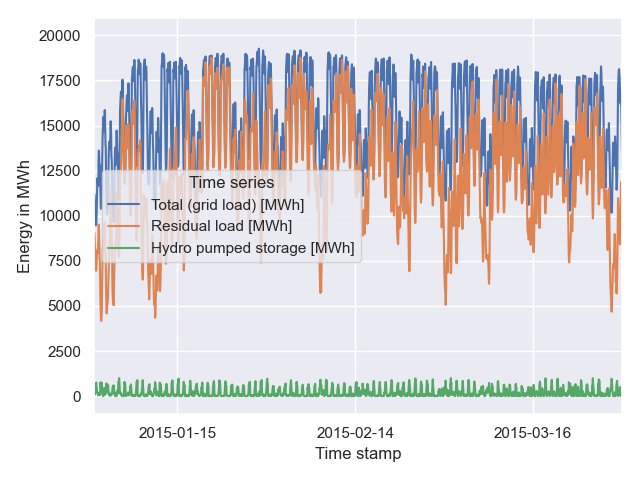

In [13]:
fig, axs = plt.subplots()
sns.lineplot(data=dfm, x=dfm.index, y="Energy in MWh", hue="Time series", ax=axs)
# plt.title("Training data")
axs.set_xlim([datetime.date(2015, 1, 1), datetime.date(2015, 3, 31)])
axs.xaxis.set_major_locator(ticker.MaxNLocator(3))
plt.tight_layout()
plt.savefig("time_series.png", bbox_inches='tight', pad_inches=0.1)

## Deskriptive Analyse des Datensatzes

Als nächstes betrachten wir die Statistiken des Datensatzes.

Wie sich bereits bei der Visualisierung angedeutet hat, sind die Merkmale verschieden verteilt. Sie unterscheiden sich deutlich in ihren Mittelwerten und Standardabweichungen.

In [14]:
df.describe()

,Total (grid load) [MWh],Residual load [MWh],Hydro pumped storage [MWh]
count,72287.000000,72287.000000,72287.000000
mean,14222.391218,9915.525707,325.764996
std,2489.989957,3140.814998,372.773032
min,8298.500000,628.500000,0.000000
25%,12157.625000,7843.250000,32.250000
50%,14169.500000,9994.250000,173.000000
75%,16319.375000,12074.750000,522.750000
max,20212.000000,19095.750000,2171.000000


Werfen wir einen genaueren Blick auf die Histogramme der verschiedenen Merkmale/Zeitreihen, dann sehen wir, dass sich die Verteilungen unterscheiden.

<IPython.core.display.Javascript object>


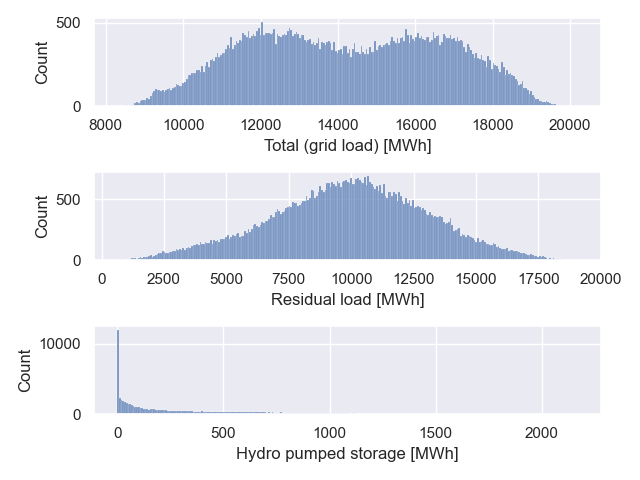

In [15]:
fig, axs = plt.subplots(3)

sns.histplot(data=df, x="Total (grid load) [MWh]", ax=axs[0], bins="sqrt")
sns.histplot(data=df, x="Residual load [MWh]", ax=axs[1], bins="sqrt")
sns.histplot(data=df, x="Hydro pumped storage [MWh]", ax=axs[2], bins="sqrt")
plt.tight_layout()
plt.savefig("raw_data.png", bbox_inches='tight', pad_inches=0.1)

## Aufteilen des Datensatzes

Wichtig ist es für jedes Verfahren, bei dem Parameter optimiert werden, den Datensatz in Trainings-, Validierungs-, und Testsets zu unterteilen. Speziell bei Zeitreihen ist es hier wichtig, einige Gegebenheiten von letzteren zu berücksichtigen:

- Die Daten werden nicht randomisiert, so dass aufeinanderfolgende Samples immer noch denselben Zeitbezug besitzen
- Validierungs- und Testset sollten nach dem Trainingsset folgen. Es ist realistisch, dass Daten, die nach dem Training des Modells gesammelt werden, ausgewertet werden.

Von unserem Datensatz trennen wir die letzten 10% als Testset ab.

In [16]:
training_length = round(.9*len(df))

## Vorverarbeitung der Daten

Generell ist es immer wichtig, die Merkmale vorzuverarbeiten, bevor irgendein Modell trainiert wird. Im einfachsten Sinne kann man die Merkmale normalisieren, beispielsweise den Mittelwert subtrahieren und durch die Standardabweichung dividieren. Es gibt auch andere Methoden, beispielsweise kann den Wertebereich explizit einschränken oder andere Verteilungsfunktionen annehmen.

In diesem Tutorial werden wir nun den Effekt verschiedener Skalierungsmethoden genauer betrachten, und am Ende eine angepasste Form der Skalierung auswählen.

Es ist noch wichtig, dass man die jeweiligen Skalierungskonstanten nur aus den Trainingsdaten berechnet. Das Modell hat keinen Zugang auf die Werte in den Validierungs- und Testsets.

In [17]:
def build_visualization_widget(plot_func, scaler, X, X_train):
    def visualize(func, X, X_train, axs, scaler):
        func(scaler, X, X_train, axs)
    _, axs = plt.subplots(3)
    interact(lambda **scaler: visualize(my_custom_plot, **scaler, X=X,
                                        X_train=X_train, axs=axs), **scaler)

In [18]:
def my_custom_plot(scaler, X, X_train, axs):
    scaler.fit(X_train)
    X_trf = scaler.transform(X)
    [ax.clear() for ax in axs]
    [sns.histplot(x=X_trf[:, k], ax=axs[k], bins="sqrt") for k in range(3)]
    plt.tight_layout()

In [19]:
selected_columns = ["Total (grid load) [MWh]",
                    "Residual load [MWh]",
                    "Hydro pumped storage [MWh]"]

<IPython.core.display.Javascript object>


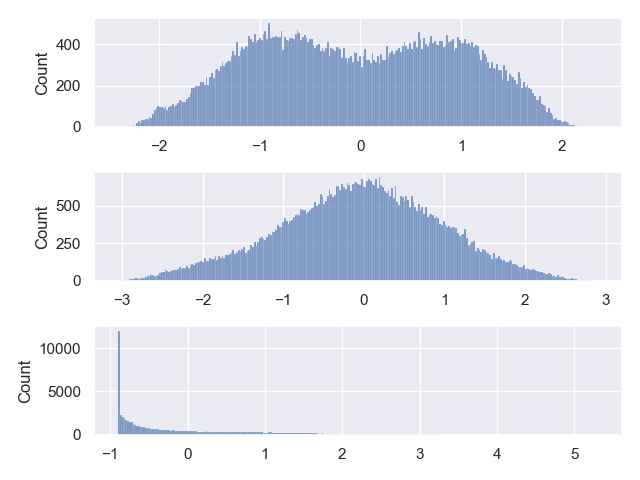

interactive(children=(Dropdown(description='scaler', options=(StandardScaler(), MinMaxScaler(), Normalizer(), …

In [20]:
X = df.loc[:, selected_columns]


df_train = df.iloc[:training_length][selected_columns]

df_test = df.iloc[training_length:][selected_columns]

estimators = {'scaler': [StandardScaler(), MinMaxScaler(),
                         Normalizer(), RobustScaler(), MaxAbsScaler(),
                         PowerTransformer()]}
build_visualization_widget(plot_func=my_custom_plot,
                           scaler=estimators, X=X, X_train=df_train)

Das Merkmal "Pumpspeicher [MWh] Originalauflösungen" unterscheidet sich deutlich von den anderen Merkmalen. Deshalb wählen wir für dieses Merkmal den ``PowerTransformer()``. Für die übrigen Merkmale verwenden wir den ``RobustScaler``, der schlichtweg etwas robuster als der ``StandardScaler()`` ist.

In [21]:
trf = ColumnTransformer(transformers=[("robust_scaler", RobustScaler(), selected_columns[:2]),
                                      ("yeo-johnson", PowerTransformer(), [selected_columns[2]]),])

In [22]:
df_train = df.iloc[:training_length][selected_columns]

df_test = df.iloc[training_length:][selected_columns]

trf.fit(df_train)

ColumnTransformer(transformers=[('robust_scaler', RobustScaler(),
                                 ['Total (grid load) [MWh]',
                                  'Residual load [MWh]']),
                                ('yeo-johnson', PowerTransformer(),
                                 ['Hydro pumped storage [MWh]'])])

<IPython.core.display.Javascript object>


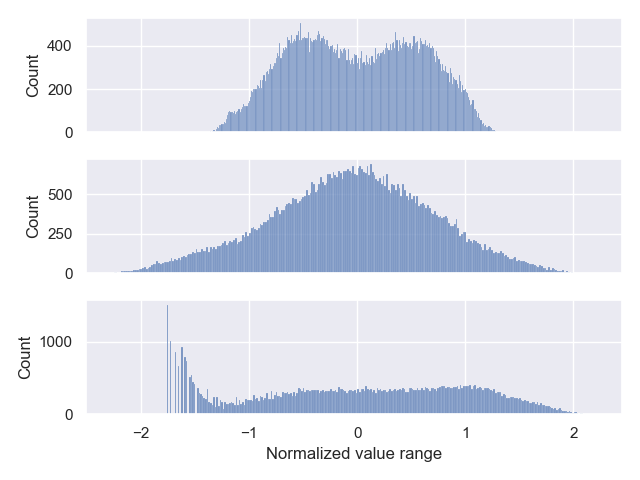

In [23]:
fig, axs = plt.subplots(3, sharex="all")

X_trf = trf.transform(X)

sns.histplot(x=X_trf[:, 0], ax=axs[0], bins="sqrt")
sns.histplot(x=X_trf[:, 1], ax=axs[1], bins="sqrt")
sns.histplot(x=X_trf[:, 2], ax=axs[2], bins="sqrt")
axs[-1].set_xlabel("Normalized value range")
plt.tight_layout()
plt.savefig("normalized_data.png", bbox_inches='tight', pad_inches=0.1)

In [24]:
df_train["Target"] = df_train["Total (grid load) [MWh]"].shift(periods=-1)
df_train.dropna(inplace=True)
df_test["Target"] = df_test["Total (grid load) [MWh]"].shift(periods=-1)
df_test.dropna(inplace=True)

In [25]:
df_train

,Total (grid load) [MWh],Residual load [MWh],Hydro pumped storage [MWh],Target
Time stamp,,,,
2015-01-01 00:00:00,11210.00,9051.75,123.00,11009.50
2015-01-01 01:00:00,11009.50,8835.00,87.50,10650.00
2015-01-01 02:00:00,10650.00,8386.50,86.25,10258.00
2015-01-01 03:00:00,10258.00,7980.00,285.25,10035.25
2015-01-01 04:00:00,10035.25,7721.50,430.25,9940.25
...,...,...,...,...
2022-06-03 13:00:00,15850.50,6607.00,1049.75,15438.75
2022-06-03 14:00:00,15438.75,7082.25,884.50,15138.25
2022-06-03 15:00:00,15138.25,7941.50,418.00,14956.50


In [26]:
df_test

,Total (grid load) [MWh],Residual load [MWh],Hydro pumped storage [MWh],Target
Time stamp,,,,
2022-06-03 19:00:00,14660.75,11655.00,2.00,14256.25
2022-06-03 20:00:00,14256.25,11633.25,2.00,13404.00
2022-06-03 21:00:00,13404.00,10791.25,2.25,12826.50
2022-06-03 22:00:00,12826.50,10074.75,8.75,12006.00
2022-06-03 23:00:00,12006.00,9316.00,37.50,11101.50
...,...,...,...,...
2023-03-31 18:00:00,14341.75,9554.75,6.25,14451.50
2023-03-31 19:00:00,14451.50,10361.00,40.50,14322.75
2023-03-31 20:00:00,14322.75,9799.75,39.50,13740.50


## Naives Basismodell

Bevor wir irgendein Modell zur Vorhersage von Zeitreihen trainieren, benötigen wir eine naive Basislinie, also ein Modell, das wir eigentlich nicht trainieren müssen. Die Vorhersageleistung dieses Modells können wir später als Vergleich mit den komplizierteren Modellen heranziehen.

Unsere erste Aufgabe ist es, die nächste Netzlast vorherzusagen. Eine naive Basislinie dafür ist es, schlichtweg keine Änderung vorherzusagen, also die aktuelle Netzlast auf die nächste Stunde zu kopieren. Dies scheint auf Basis der bisherigen Datenanalyse sinnvoll, denn die Last verändert sich in kurzen Zeitabschnitten nur langsam. Natürlich funktioniert diese Basislinie schlechter, je weiter man in die Zukunft vorhersagt.

In [27]:
selected_columns = ["Total (grid load) [MWh]"]

Visualisieren wir die Vorhersageleistung dieses naiven Basismodells, so ist zu erkennen, dass es grundsätzlich schon nicht so schlecht funktioniert.

- Die blaue Linie zeigt die Eingabe für unser Modell, also die originale Netzlast zu jedem aktuellen Zeitschritt.
- Die orange-farbene Linie zeigt die Zielausgabe für unser Modell, mit der wir die tatsächliche Ausgabe berechnen, also die originale Netzlast für den jeweils nächsten Zeitschritt.

Aus Gründen der Übersichtlichkeit wurde die "vorhergesagte" Ausgabe nicht mit visualisiert. Dies wäre wieder die Gesamtlast für den jeweils aktuellen Zeitschritt.

<IPython.core.display.Javascript object>


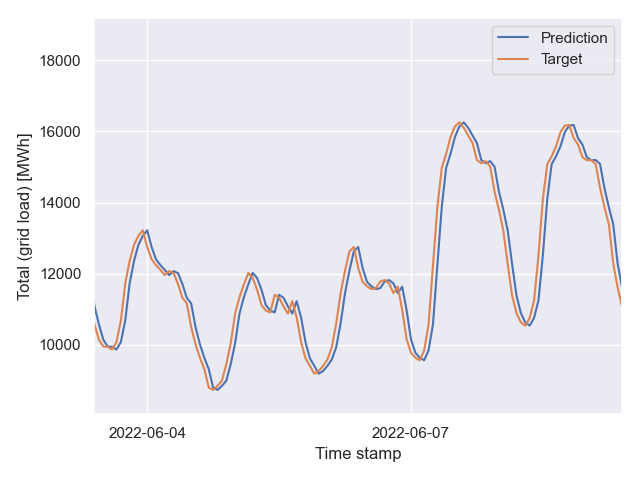

In [28]:
fig, axs = plt.subplots()

sns.lineplot(data=df_test, x=df_test.index, y=selected_columns[0], label="Prediction", markers=True, ax=axs)
sns.lineplot(data=df_test, x=df_test.index, y="Target", label="Target", markers=True, ax=axs)
axs.set_xlim([datetime.date(2022, 6, 4), datetime.date(2022, 6, 9)])
axs.xaxis.set_major_locator(ticker.MaxNLocator(2))
plt.tight_layout()
plt.savefig("baseline_time_series.png", bbox_inches='tight', pad_inches=0.1)

In [29]:
print(mean_squared_error(df_test["Target"], df_test[selected_columns]))
print(mean_absolute_error(df_test["Target"], df_test[selected_columns]))
print(r2_score(df_test["Target"], df_test[selected_columns]))

342181.4485680686
453.74903154399556
0.93097808712169


## Lineare Regression

Nun kommen wir zu dem einfachsten trainierbaren Modell, das wir für die Zeitreihenvorhersage verwenden könnnen: Lineare Regression

Hier wollen wir eine lineare Transformation zwischen der Ein- und der Ausgabe einfügen. Auf diese Art ist die Ausgabe des aktuellen Zeitschrittes abhängig von der aktuellen Eingabe.

Da wir nun tatsächlich ein Modell trainieren, müssen wir die Skalierung der Daten mit berücksichtigen. Deshalb scheint das Modell zunächst relativ komplex zu sein. Folgende Schritte werden durchgeführt:

1. Normalisieren der Eingangsdaten. Hier wird der ``RobustScaler()`` verwendet, da wir zunächst nur mit der Gesamtlast arbeiten.
2. Lineare Abbildung von den normalisierten Eingangsdaten auf die ebenfalls mit dem ``RobustScaler()`` normalisierte Zielfunktion.
3. Inverse Skalierung der berechneten Ausgaben mithilfe des zweiten ``RobustScaler()``.

In [30]:
try:
    model = load(f"../results/linear_regression.joblib")
except FileNotFoundError:
    model = Pipeline(steps=[
        ("scaler", RobustScaler()),
        ("regressor", TransformedTargetRegressor(transformer=RobustScaler()))])
    model.fit(X=df_train[selected_columns], y=df_train["Target"])
    dump(model, f"../results/linear_regression.joblib")

In [31]:
model

Pipeline(steps=[('scaler', RobustScaler()),
                ('regressor',
                 TransformedTargetRegressor(transformer=RobustScaler()))])

<IPython.core.display.Javascript object>


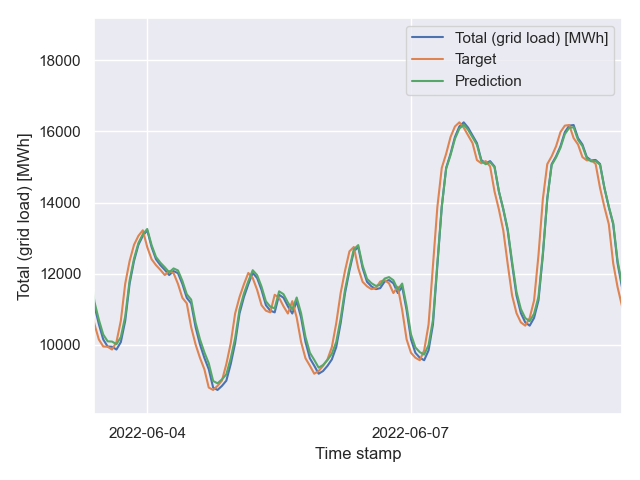

In [32]:
fig, axs = plt.subplots()

y_pred = model.predict(df_test[selected_columns])

sns.lineplot(data=df_test, x=df_test.index, y=selected_columns[0], label=selected_columns[0], markers=True, ax=axs)
sns.lineplot(data=df_test, x=df_test.index, y="Target", label="Target", ax=axs)
sns.lineplot(x=df_test.index, y=y_pred, label="Prediction", ax=axs)
axs.set_xlim([datetime.date(2022, 6, 4), datetime.date(2022, 6, 9)])
axs.xaxis.set_major_locator(ticker.MaxNLocator(2))
plt.tight_layout()
plt.savefig("linear_model_time_series.png", bbox_inches='tight', pad_inches=0.1)

In [33]:
print(mean_squared_error(df_test.loc[:, "Target"], y_pred))
print(mean_absolute_error(df_test.loc[:, "Target"], y_pred))
print(r2_score(df_test.loc[:, "Target"], y_pred))

337162.8391719553
457.44038237894756
0.931990398051924


<IPython.core.display.Javascript object>


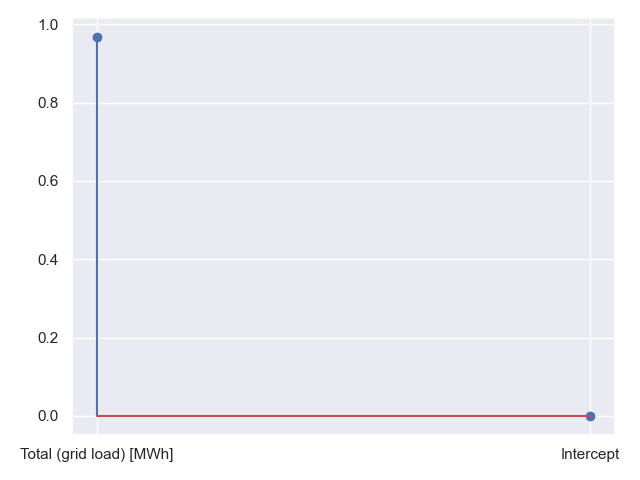

In [34]:
fig, axs = plt.subplots()
coef_ = model.named_steps["regressor"].regressor_.coef_
intercept_ = [model.named_steps["regressor"].regressor_.intercept_]

axs.stem(np.arange(2), np.hstack((coef_, intercept_)))
plt.xticks(np.arange(2), selected_columns + ["Intercept"])
plt.tight_layout()
plt.savefig("linear_model_coefs.png", bbox_inches='tight', pad_inches=0.1)

## Ridge Regression

Ein Problem bei linearer Regression ist häufig die Überanpassung des Modells auf die Trainingsdaten. Abhilfe dafür kann die Ridge Regression schaffen. Diese führt einen Strafterm $\alpha$ ein, der große Gewichte in den Koeffizienten bestraft. Dies ist nicht zwangsläufig notwendig, wir sollten es aber dennoch berücksichtigen.

An der grundsätzlichen Herangehensweise ändert sich dadurch nichts: Wir wollen weiterhin eine lineare Transformation zwischen der Ein- und der Ausgabe einfügen.

In unserem bisherigen Modell werden wir lediglich im ``TransformedTargetRegressor()`` einen anderen Regressor (``Ridge``) auswählen.

Eine Besonderheit gibt es nichtsdestotrotz: Wir müssen $\alpha$, einen so genannten Hyper-Parameter, optimieren. Dafür nutzen wir eine fünffache Kreuzvalidierung auf dem Trainingsset. Dies gibt uns statistische Sicherheit.

In [35]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    max_train_size=10000,  # Maximum size for a single training set.
    test_size=1000,  # Used to limit the size of the test set.
)

In [36]:
try:
    model = load(f"../results/ridge_regression.joblib")
except FileNotFoundError:
    base_model = Pipeline(steps=[
        ("scaler", RobustScaler()),
        ("regressor", TransformedTargetRegressor(regressor=Ridge(), transformer=RobustScaler()))])
    
    model = RandomizedSearchCV(
        estimator=base_model,
        param_distributions={"regressor__regressor__alpha": loguniform(1e-5, 1e1)},
        n_iter=200, random_state=42, cv=ts_cv, n_jobs=-1, verbose=10)
    model.fit(X=df_train[selected_columns], y=df_train["Target"])
    dump(model, f"../results/ridge_regression.joblib")

<IPython.core.display.Javascript object>


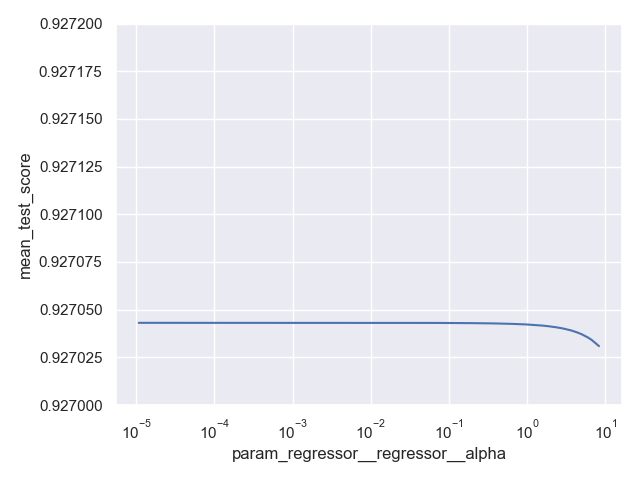

In [37]:
cv_results = pd.DataFrame(model.cv_results_)

fig, axs = plt.subplots()
sns.lineplot(data=cv_results, x="param_regressor__regressor__alpha", y="mean_test_score", ax=axs)
axs.set_ylim((0.927, .9272))
axs.set_xscale('log')
plt.tight_layout()

<IPython.core.display.Javascript object>


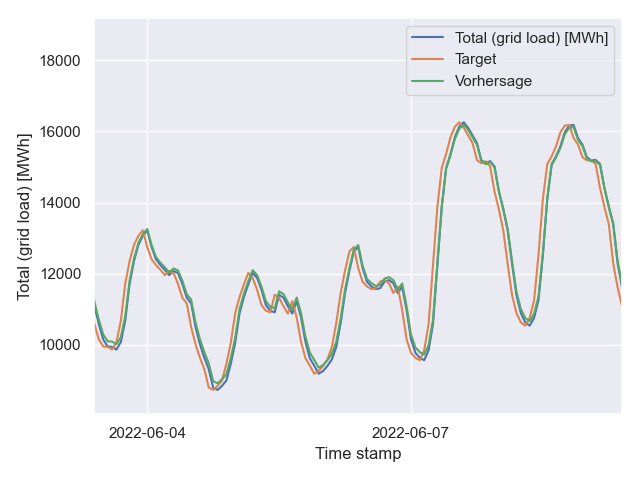

In [38]:
fig, axs = plt.subplots()

y_pred = model.predict(df_test[selected_columns])

sns.lineplot(data=df_test, x=df_test.index, y=selected_columns[0], label=selected_columns[0], markers=True, ax=axs)
sns.lineplot(data=df_test, x=df_test.index, y="Target", label="Target", ax=axs)
sns.lineplot(x=df_test.index, y=y_pred, label="Vorhersage", ax=axs)
axs.set_xlim([datetime.date(2022, 6, 4), datetime.date(2022, 6, 9)])
axs.xaxis.set_major_locator(ticker.MaxNLocator(2))
plt.tight_layout()
plt.savefig("linear_model_time_series.png", bbox_inches='tight', pad_inches=0.1)

In [39]:
print(mean_squared_error(df_test.loc[:, "Target"], y_pred))
print(mean_absolute_error(df_test.loc[:, "Target"], y_pred))
print(r2_score(df_test.loc[:, "Target"], y_pred))

337162.83919046214
457.4403825214905
0.931990398048191


<IPython.core.display.Javascript object>


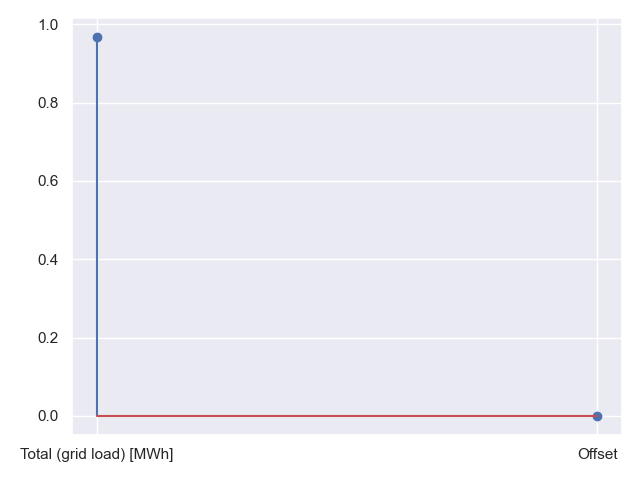

In [40]:
fig, axs = plt.subplots()
coef_ = model.best_estimator_.named_steps["regressor"].regressor_.coef_
intercept_ = [model.best_estimator_.named_steps["regressor"].regressor_.intercept_]

axs.stem(np.arange(2), np.hstack((coef_, intercept_)))
plt.xticks(np.arange(2), selected_columns + ["Offset"])
plt.tight_layout()

## Mehrschichtiges Perzeptron

Nun kommen wir zum deutlich komplexeren mehrschichtigen Perzeptron. Dies ist das einfachste neuronale Netzwerk, mit dem wir Zeitreihenvorhersage betreiben können. Weiterhin ist die Ausgabe des aktuellen Zeitschrittes lediglich abhängig von der aktuellen Eingabe. Letztere wird allerdings mithilfe einer Nichtlinearität verzerrt und die Dimension in der so genannten verdeckten Schicht erhöht. Auf diese Art kann man komplexere Probleme lösen.

In der ``scikit-learn`` ist dies relativ einfach zu implementieren: Wir ersetzen lediglich unser ``Ridge()``-Objekt durch einen ``MLPRegressor()``.

Es ist noch sinnvoll zu erwähnen, dass wir nun deutlich mehr Hyper-Parameter zu optimieren haben. Für dieses Tutorial beschränken wir uns nun auf $\alpha$ und auf die initiale Lernrate. Es ist allerdings zu erwähnen, dass es deutlich mehr als nur diese beiden Hyper-Parameter gibt.

In [41]:
try:
    model = load(f"../results/1_layer_mlp.joblib")
except FileNotFoundError:
    base_model = Pipeline(steps=[
        ("scaler", RobustScaler()),
        ("regressor", TransformedTargetRegressor(
            regressor=MLPRegressor(hidden_layer_sizes=(16, ),
                                   random_state=42),
            transformer=RobustScaler()))])
    
    model = RandomizedSearchCV(
        estimator=base_model,
        param_distributions={"regressor__regressor__alpha": loguniform(1e-5, 1e1),
                             "regressor__regressor__learning_rate_init": loguniform(1e-5, 1e-1)},
        n_iter=200, random_state=42, cv=ts_cv, n_jobs=-1, verbose=10)
    model.fit(X=df_train[selected_columns], y=df_train["Target"])
    dump(model, f"../results/1_layer_mlp.joblib")

<IPython.core.display.Javascript object>


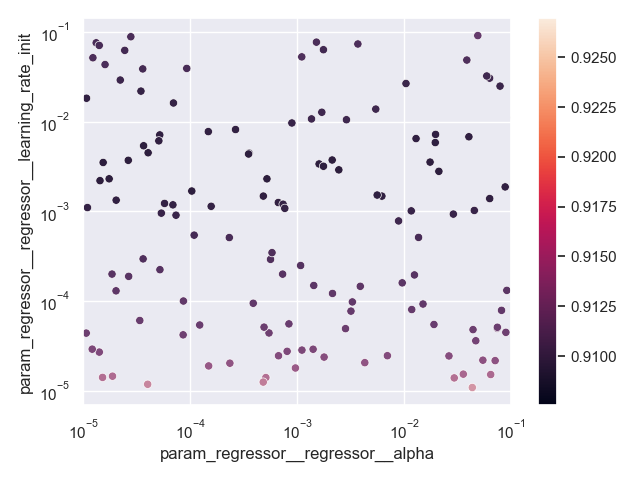

C:\Users\Steiner\AppData\Local\Temp\ipykernel_18124\4107104236.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  axs.figure.colorbar(sm)


In [42]:
cv_results = pd.DataFrame(model.cv_results_)

fig, axs = plt.subplots()
sns.scatterplot(data=cv_results, x="param_regressor__regressor__alpha",
                y="param_regressor__regressor__learning_rate_init", hue="mean_test_score", ax=axs)

norm = plt.Normalize(cv_results['mean_test_score'].min(), cv_results['mean_test_score'].max())
sm = plt.cm.ScalarMappable(norm=norm)
sm.set_array([])
axs.get_legend().remove()
axs.figure.colorbar(sm)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlim((1e-5, 1e1))
axs.set_xlim((1e-5, 1e-1))
plt.tight_layout()

<IPython.core.display.Javascript object>


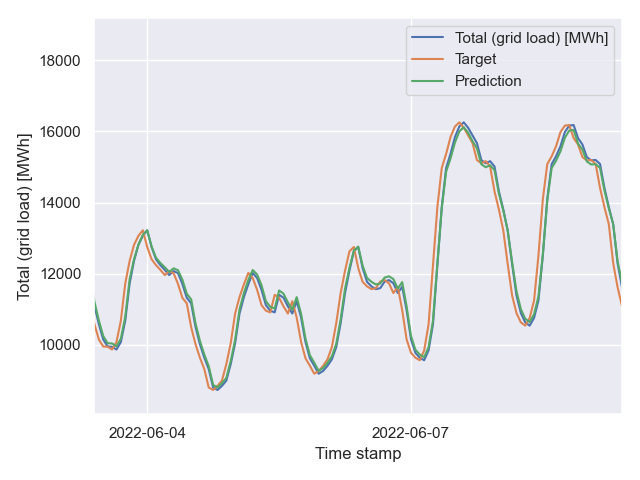

In [43]:
fig, axs = plt.subplots()

y_pred = model.predict(df_test[selected_columns])

sns.lineplot(data=df_test, x=df_test.index, y=selected_columns[0], label=selected_columns[0], markers=True, ax=axs)
sns.lineplot(data=df_test, x=df_test.index, y="Target", label="Target", ax=axs)
sns.lineplot(x=df_test.index, y=y_pred, label="Prediction", ax=axs)
axs.set_xlim([datetime.date(2022, 6, 4), datetime.date(2022, 6, 9)])
axs.xaxis.set_major_locator(ticker.MaxNLocator(2))
plt.tight_layout()
plt.savefig("mlp_time_series.png", bbox_inches='tight', pad_inches=0.1)

In [44]:
print(mean_squared_error(df_test.loc[:, "Target"], y_pred))
print(mean_absolute_error(df_test.loc[:, "Target"], y_pred))
print(r2_score(df_test.loc[:, "Target"], y_pred))

337201.7858927014
454.840154933033
0.9319825420527824


Beim mehrschichtigen Perzeptron ist es noch interessant zu untersuchen, ob wir beispielsweise mit zusätzlichen Schichten die Leistungsfähigkeit verbessern können.

In [45]:
try:
    model = load(f"../results/2_layer_mlp.joblib")
except FileNotFoundError:
    base_model = Pipeline(steps=[
        ("scaler", RobustScaler()),
        ("regressor", TransformedTargetRegressor(
            regressor=MLPRegressor(hidden_layer_sizes=(16, 16, ),
                                   random_state=42),
            transformer=RobustScaler()))])
    
    model = RandomizedSearchCV(
        estimator=base_model,
        param_distributions={"regressor__regressor__alpha": loguniform(1e-5, 1e1),
                             "regressor__regressor__learning_rate_init": loguniform(1e-5, 1e-1)},
        n_iter=200, random_state=42, cv=ts_cv, n_jobs=-1, verbose=10)
    model.fit(X=df_train[selected_columns], y=df_train["Target"])
    dump(model, f"../results/2_layer_mlp.joblib")

<IPython.core.display.Javascript object>


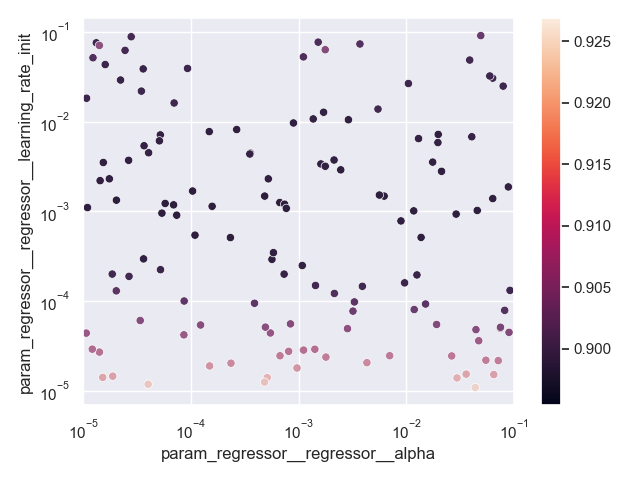

C:\Users\Steiner\AppData\Local\Temp\ipykernel_18124\4107104236.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  axs.figure.colorbar(sm)


In [46]:
cv_results = pd.DataFrame(model.cv_results_)

fig, axs = plt.subplots()
sns.scatterplot(data=cv_results, x="param_regressor__regressor__alpha",
                y="param_regressor__regressor__learning_rate_init", hue="mean_test_score", ax=axs)

norm = plt.Normalize(cv_results['mean_test_score'].min(), cv_results['mean_test_score'].max())
sm = plt.cm.ScalarMappable(norm=norm)
sm.set_array([])
axs.get_legend().remove()
axs.figure.colorbar(sm)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlim((1e-5, 1e1))
axs.set_xlim((1e-5, 1e-1))
plt.tight_layout()

<IPython.core.display.Javascript object>


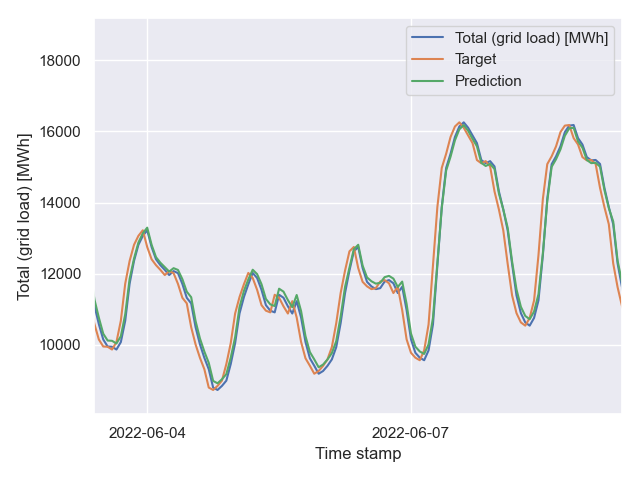

In [47]:
fig, axs = plt.subplots()

y_pred = model.predict(df_test[selected_columns])

sns.lineplot(data=df_test, x=df_test.index, y=selected_columns[0], label=selected_columns[0], markers=True, ax=axs)
sns.lineplot(data=df_test, x=df_test.index, y="Target", label="Target", ax=axs)
sns.lineplot(x=df_test.index, y=y_pred, label="Prediction", ax=axs)
axs.set_xlim([datetime.date(2022, 6, 4), datetime.date(2022, 6, 9)])
axs.xaxis.set_major_locator(ticker.MaxNLocator(2))
plt.tight_layout()
plt.savefig("mlp_time_series.png", bbox_inches='tight', pad_inches=0.1)

In [48]:
print(mean_squared_error(df_test.loc[:, "Target"], y_pred))
print(mean_absolute_error(df_test.loc[:, "Target"], y_pred))
print(r2_score(df_test.loc[:, "Target"], y_pred))

338270.4729370154
459.5529466846737
0.9317669756497073


In [49]:
try:
    model = load(f"../results/3_layer_mlp.joblib")
except FileNotFoundError:
    base_model = Pipeline(steps=[
        ("scaler", RobustScaler()),
        ("regressor", TransformedTargetRegressor(
            regressor=MLPRegressor(hidden_layer_sizes=(16, 16, 16, ),
                                   random_state=42),
            transformer=RobustScaler()))])
    
    model = RandomizedSearchCV(
        estimator=base_model,
        param_distributions={"regressor__regressor__alpha": loguniform(1e-5, 1e1),
                             "regressor__regressor__learning_rate_init": loguniform(1e-5, 1e-1)},
        n_iter=200, random_state=42, cv=ts_cv, n_jobs=-1, verbose=10)
    model.fit(X=df_train[selected_columns], y=df_train["Target"])
    dump(model, f"../results/3_layer_mlp.joblib")

<IPython.core.display.Javascript object>


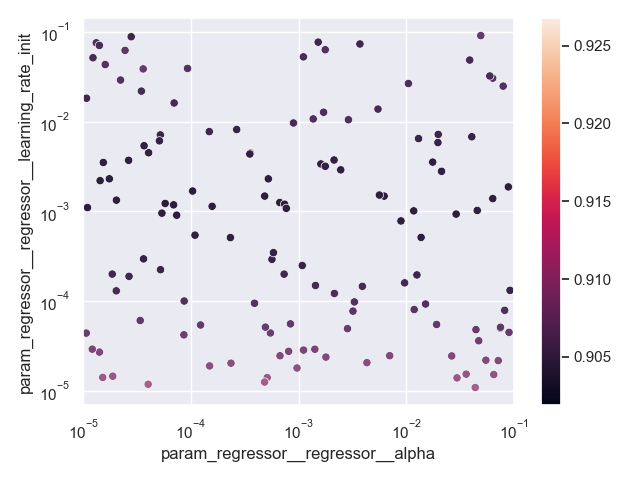

C:\Users\Steiner\AppData\Local\Temp\ipykernel_18124\4107104236.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  axs.figure.colorbar(sm)


In [50]:
cv_results = pd.DataFrame(model.cv_results_)

fig, axs = plt.subplots()
sns.scatterplot(data=cv_results, x="param_regressor__regressor__alpha",
                y="param_regressor__regressor__learning_rate_init", hue="mean_test_score", ax=axs)

norm = plt.Normalize(cv_results['mean_test_score'].min(), cv_results['mean_test_score'].max())
sm = plt.cm.ScalarMappable(norm=norm)
sm.set_array([])
axs.get_legend().remove()
axs.figure.colorbar(sm)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlim((1e-5, 1e1))
axs.set_xlim((1e-5, 1e-1))
plt.tight_layout()

<IPython.core.display.Javascript object>


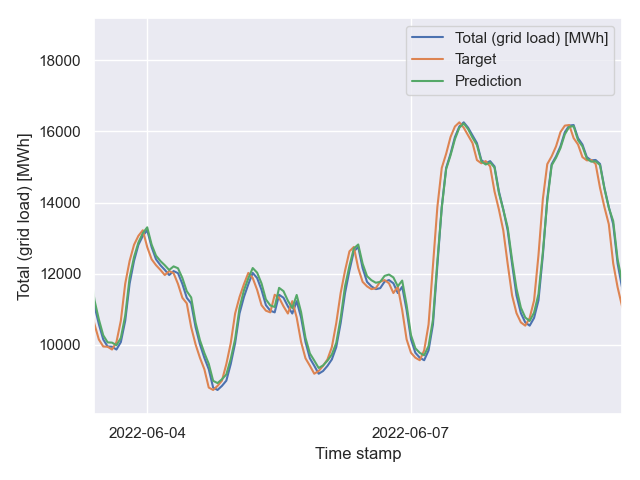

In [51]:
fig, axs = plt.subplots()

y_pred = model.predict(df_test[selected_columns])

sns.lineplot(data=df_test, x=df_test.index, y=selected_columns[0], label=selected_columns[0], markers=True, ax=axs)
sns.lineplot(data=df_test, x=df_test.index, y="Target", label="Target", ax=axs)
sns.lineplot(x=df_test.index, y=y_pred, label="Prediction", ax=axs)
axs.set_xlim([datetime.date(2022, 6, 4), datetime.date(2022, 6, 9)])
axs.xaxis.set_major_locator(ticker.MaxNLocator(2))
plt.tight_layout()
plt.savefig("mlp_time_series.png", bbox_inches='tight', pad_inches=0.1)

In [52]:
print(mean_squared_error(df_test.loc[:, "Target"], y_pred))
print(mean_absolute_error(df_test.loc[:, "Target"], y_pred))
print(r2_score(df_test.loc[:, "Target"], y_pred))

339695.5215590652
460.8950815572475
0.9314795270394741


## Echo State Network

Ein Take-away der bisherigen Experimente ist sicherlich, dass die Vorhersage auf Basis lediglich des aktuellen Zeitschrittes selbst mit komplexeren Modellen nicht zufriedenstellend war. Deshalb gehen wir nun einen Schritt weiter und führen mit dem Echo State Network die Zeitreihenvorhersage auf Basis mehrerer Zeitschritte durch. Die Eingabe ist weiterhin lediglich der aktuelle Zeitschritt. Durch die rekurrenten Verbindungen speichert jedoch das Echo State Network implizit vergangene Eingaben in seiner verdeckten Schicht.

Die grundsätzliche Methode bleibt weiterhin gleich, wir ersetzen nun lediglich unser ``MLPRegressor()``-Objekt durch einen ``ESNRegressor()``.

Aus Erfahrung kann man sagen, dass die Optimierung der Hyper-Parameter hier noch einen deutlich größeren Einfluss auf die Leistungsfähigkeit unseres Modells besitzt. Deshalb optimieren wir hier insgesamt vier Hyper-Parameter.

In [53]:
initially_fixed_params = {
    'hidden_layer_size': 16, 'input_activation': 'identity',
    'k_in': 1, 'input_scaling': 0.4, 'bias_scaling': 0.0,
    'spectral_radius': 0.0, 'reservoir_activation': 'tanh',
    'leakage': 1.0, 'bidirectional': False, 'k_rec': 5,
    'alpha': 1e-3, 'random_state': 42}

step1_esn_params = {'regressor__regressor__input_scaling': uniform(loc=0.01, scale=1.91),
                    'regressor__regressor__spectral_radius': uniform(loc=0, scale=1.)}
step2_esn_params = {'regressor__regressor__leakage': loguniform(0.00001, 0.99999)}
step3_esn_params = {'regressor__regressor__bias_scaling': uniform(loc=0, scale=2)}
step4_esn_params = {'regressor__regressor__alpha': loguniform(0.00001, 9.99999)}

kwargs_step_1 = {'n_iter': 200, 'random_state': 42, 'verbose': 10,
                 'n_jobs': -1, 'cv': ts_cv}
kwargs_step_n = {'n_iter': 50, 'random_state': 42, 'verbose': 10,
                 'n_jobs': -1, 'cv': ts_cv}
searches = [
    ('step1', RandomizedSearchCV, step1_esn_params, kwargs_step_1),
    ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step_n),
    ('step3', RandomizedSearchCV, step3_esn_params, kwargs_step_n),
    ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step_n)]

base_model = Pipeline(steps=[
        ("scaler", RobustScaler()),
        ("regressor", TransformedTargetRegressor(
            regressor=ESNRegressor(**initially_fixed_params),
            transformer=RobustScaler()))])


try:
    model = load(f'../results/echo_state_network.joblib')
except FileNotFoundError:
    model = SequentialSearchCV(
        base_model, searches=searches).fit(X=df_train[selected_columns],
                                           y=df_train["Target"])
    dump(model, f'../results/echo_state_network.joblib')

In [54]:
model.all_best_params_

{'step1': {'regressor__regressor__input_scaling': 1.0590229295886902,
  'regressor__regressor__spectral_radius': 0.7145959227000623},
 'step2': {'regressor__regressor__leakage': 0.7072045538330198},
 'step3': {'regressor__regressor__bias_scaling': 0.041168988591604894},
 'step4': {'regressor__regressor__alpha': 0.00035700950361612394}}

<IPython.core.display.Javascript object>


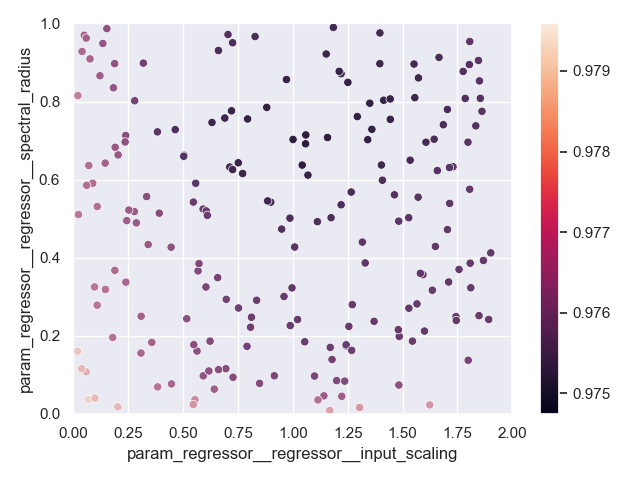

C:\Users\Steiner\AppData\Local\Temp\ipykernel_18124\2586063743.py:13: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  axs.figure.colorbar(sm)


In [55]:
cv_results = pd.DataFrame(model.all_cv_results_['step1'])

fig, axs = plt.subplots()
sns.scatterplot(data=cv_results,
                x='param_regressor__regressor__input_scaling', y='param_regressor__regressor__spectral_radius',
                hue='mean_test_score', ax=axs)
norm = plt.Normalize(cv_results['mean_test_score'].min(), cv_results['mean_test_score'].max())
sm = plt.cm.ScalarMappable(norm=norm)
sm.set_array([])
axs.set_xlim((.0, 2.))
axs.set_ylim((.0, 1.))
axs.get_legend().remove()
axs.figure.colorbar(sm)
plt.tight_layout()

<IPython.core.display.Javascript object>


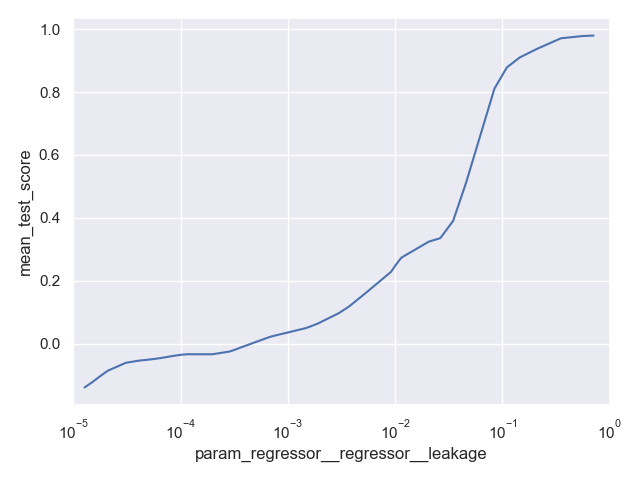

In [56]:
cv_results = pd.DataFrame(model.all_cv_results_["step2"])

fig, axs = plt.subplots()
sns.lineplot(data=cv_results, x="param_regressor__regressor__leakage", y="mean_test_score", ax=axs)
axs.set_xlim((1e-5, 1.))
axs.set_xscale('log')

plt.tight_layout()

<IPython.core.display.Javascript object>


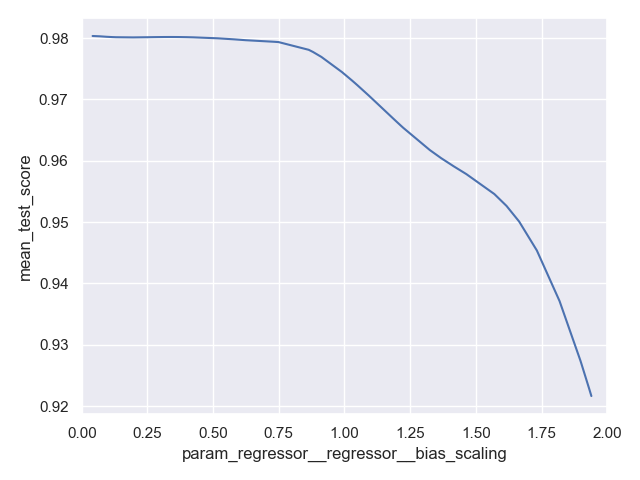

In [57]:
cv_results = pd.DataFrame(model.all_cv_results_["step3"])

fig, axs = plt.subplots()
sns.lineplot(data=cv_results, x="param_regressor__regressor__bias_scaling", y="mean_test_score", ax=axs)
axs.set_xlim((0, 2.))

plt.tight_layout()

<IPython.core.display.Javascript object>


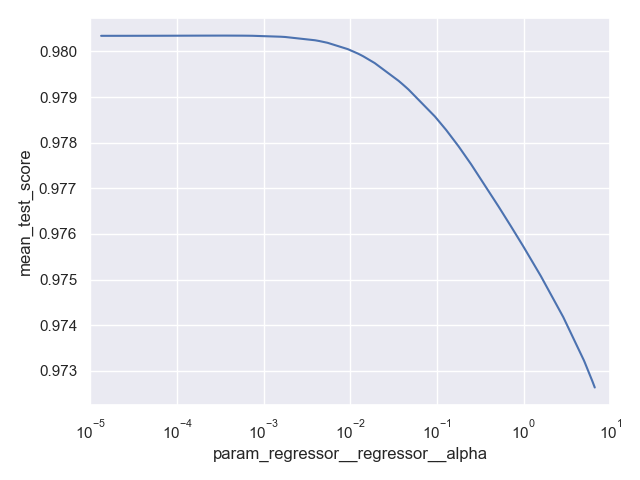

In [58]:
cv_results = pd.DataFrame(model.all_cv_results_["step4"])

fig, axs = plt.subplots()
sns.lineplot(data=cv_results, x="param_regressor__regressor__alpha", y="mean_test_score", ax=axs)
axs.set_xlim((1e-5, 10.))
axs.set_xscale('log')

plt.tight_layout()

Die Leistungsfähigkeit ist in der Tat nun deutlich besser.

C:\Users\Steiner\AppData\Local\Temp\ipykernel_18124\736670596.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots()


<IPython.core.display.Javascript object>


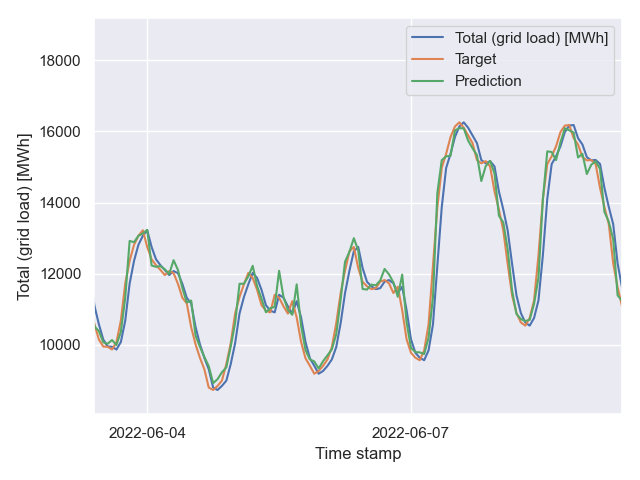

In [59]:
fig, axs = plt.subplots()

y_pred = model.predict(df_test[selected_columns])

sns.lineplot(data=df_test, x=df_test.index, y=selected_columns[0], label=selected_columns[0], markers=True, ax=axs)
sns.lineplot(data=df_test, x=df_test.index, y="Target", label="Target", ax=axs)
sns.lineplot(x=df_test.index, y=y_pred, label="Prediction", ax=axs)
axs.set_xlim([datetime.date(2022, 6, 4), datetime.date(2022, 6, 9)])
axs.xaxis.set_major_locator(ticker.MaxNLocator(2))
plt.tight_layout()
plt.savefig("esn_time_series.png", bbox_inches='tight', pad_inches=0.1)

In [60]:
print(mean_squared_error(df_test.loc[:, "Target"], y_pred))
print(mean_absolute_error(df_test.loc[:, "Target"], y_pred))
print(r2_score(df_test.loc[:, "Target"], y_pred))

99210.94033734383
238.88734989679543
0.9799880183183655


# Feature Design

Nun kommen wir zu komplexeren Features, nämlich den HAR-Features. Diese erweitern prinzipiell unsere eindimensionale Zeitreihe auf drei Dimensionen:

1. Die originale Zeitreihe
2. Gefilterte Zeitreihe (gleitender Mittelwert über fünf Zeitschritte hinweg)
3. Gefilterte Zeitreihe (gleitender Mittelwert über 22 Zeitschritte hinweg)

Ganz ohne neuronales Netzwerk kommen wir nun auf eine deutlich bessere Leistungsfähigkeit unseres linearen Modells.

Fulvio Corsi. (2009).
A Simple Approximate Long-Memory Model of Realized Volatility.
Journal of Financial Econometrics, 7, 174-196.
[10.1093/jjfinec/nbp001](https://doi.org/10.1093/jjfinec/nbp001)

In [61]:
single_step_transformer = FunctionTransformer(
    func=compute_moving_average, kw_args={"window_length": 1})
five_steps_transformer = FunctionTransformer(
    func=compute_moving_average, kw_args={"window_length": 5})
twenty_two_steps_transformer = FunctionTransformer(
    func=compute_moving_average, kw_args={"window_length": 22})
har_features = FeatureUnion(
    transformer_list=[("single_step", single_step_transformer),
                      ("five_steps", five_steps_transformer),
                      ("twenty_two_steps", twenty_two_steps_transformer)])

<IPython.core.display.Javascript object>


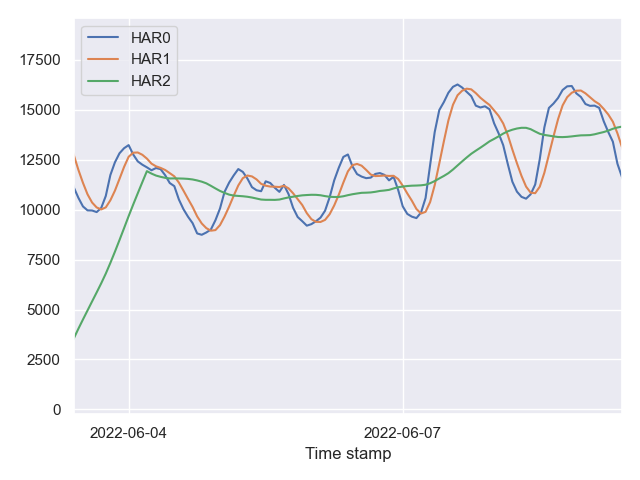

In [62]:
X_har = har_features.transform(df_test[selected_columns].values)

fig, axs = plt.subplots()

sns.lineplot(x=df_test.index, y=X_har[:, 0], label="HAR0", ax=axs)
sns.lineplot(x=df_test.index, y=X_har[:, 1], label="HAR1", ax=axs)
sns.lineplot(x=df_test.index, y=X_har[:, 2], label="HAR2", ax=axs)

axs.set_xlim([datetime.date(2022, 6, 4), datetime.date(2022, 6, 9)])
axs.xaxis.set_major_locator(ticker.MaxNLocator(2))
plt.tight_layout()
plt.savefig("har_features.png", bbox_inches='tight', pad_inches=0.1)

In [63]:
try:
    model = load(f"../results/har_linear_regression.joblib")
except FileNotFoundError:
    model = Pipeline(steps=[
        ("har_features", har_features),
        ("scaler", RobustScaler()),
        ("regressor", TransformedTargetRegressor(transformer=RobustScaler()))])
    model.fit(X=df_train[selected_columns].values, y=df_train["Target"])
    dump(model, f"../results/har_linear_regression.joblib")

<IPython.core.display.Javascript object>


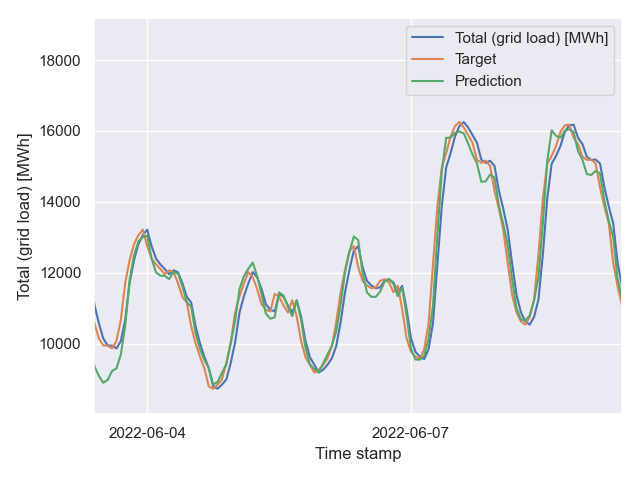

In [64]:
fig, axs = plt.subplots()

y_pred = model.predict(df_test[selected_columns].values)

sns.lineplot(data=df_test, x=df_test.index, y=selected_columns[0], label=selected_columns[0], markers=True, ax=axs)
sns.lineplot(data=df_test, x=df_test.index, y="Target", label="Target", ax=axs)
sns.lineplot(x=df_test.index, y=y_pred, label="Prediction", ax=axs)
axs.set_xlim([datetime.date(2022, 6, 4), datetime.date(2022, 6, 9)])
axs.xaxis.set_major_locator(ticker.MaxNLocator(2))
plt.tight_layout()
plt.savefig("har_linear_model_time_series.png", bbox_inches='tight', pad_inches=0.1)

In [65]:
print(mean_squared_error(df_test.loc[:, "Target"], y_pred))
print(mean_absolute_error(df_test.loc[:, "Target"], y_pred))
print(r2_score(df_test.loc[:, "Target"], y_pred))

151333.97034853377
298.359507223893
0.9694742068553509


## MLP mit HAR

In [66]:
try:
    model = load(f"../results/har_1_layer_mlp.joblib")
except FileNotFoundError:
    base_model = Pipeline(steps=[
        ("har_features", har_features),
        ("scaler", RobustScaler()),
        ("regressor", TransformedTargetRegressor(
            regressor=MLPRegressor(hidden_layer_sizes=(16, ),
                                   random_state=42),
            transformer=RobustScaler()))])
    
    model = RandomizedSearchCV(
        estimator=base_model,
        param_distributions={"regressor__regressor__alpha": loguniform(1e-5, 1e1),
                             "regressor__regressor__learning_rate_init": loguniform(1e-5, 1e-1)},
        n_iter=200, random_state=42, cv=ts_cv, n_jobs=-1, verbose=10)
    model.fit(X=df_train[selected_columns].values, y=df_train["Target"])
    dump(model, f"../results/har_1_layer_mlp.joblib")

<IPython.core.display.Javascript object>


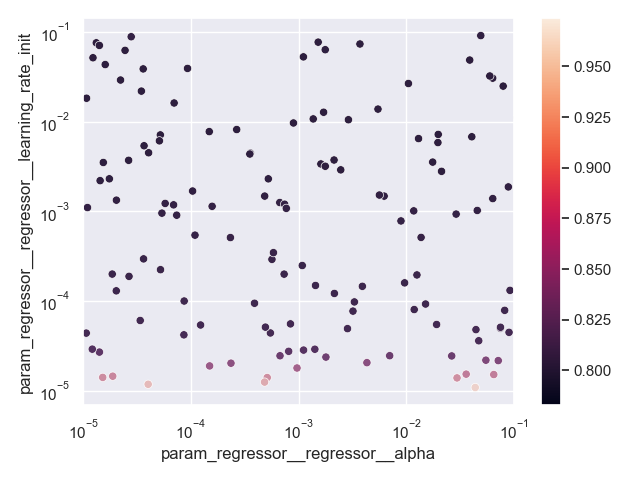

C:\Users\Steiner\AppData\Local\Temp\ipykernel_18124\4107104236.py:11: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  axs.figure.colorbar(sm)


In [67]:
cv_results = pd.DataFrame(model.cv_results_)

fig, axs = plt.subplots()
sns.scatterplot(data=cv_results, x="param_regressor__regressor__alpha",
                y="param_regressor__regressor__learning_rate_init", hue="mean_test_score", ax=axs)

norm = plt.Normalize(cv_results['mean_test_score'].min(), cv_results['mean_test_score'].max())
sm = plt.cm.ScalarMappable(norm=norm)
sm.set_array([])
axs.get_legend().remove()
axs.figure.colorbar(sm)
axs.set_xscale('log')
axs.set_yscale('log')
axs.set_xlim((1e-5, 1e1))
axs.set_xlim((1e-5, 1e-1))
plt.tight_layout()

In [68]:
cv_results["mean_fit_time"].mean(), cv_results["mean_score_time"].mean()

(1.4421850543022157, 0.0017540872097015381)

<IPython.core.display.Javascript object>


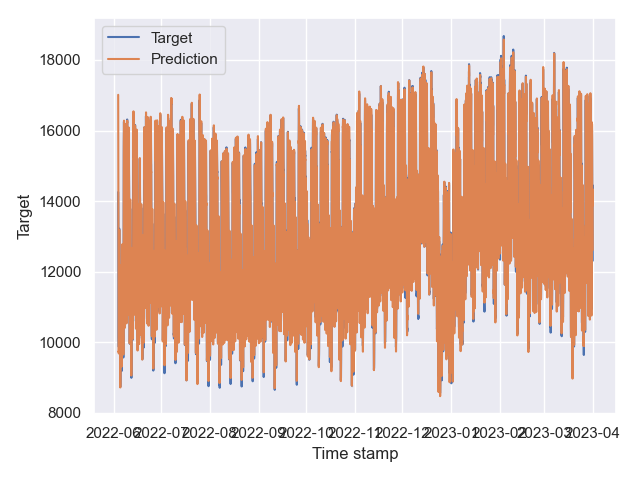

In [69]:
fig, axs = plt.subplots()

y_pred = model.predict(df_test[selected_columns].values)

sns.lineplot(data=df_test, x=df_test.index, y="Target", label="Target", ax=axs)
sns.lineplot(x=df_test.index, y=y_pred, label="Prediction", ax=axs)
plt.tight_layout()

In [70]:
print(mean_squared_error(df_test.loc[:, "Target"], y_pred))
print(mean_absolute_error(df_test.loc[:, "Target"], y_pred))
print(r2_score(df_test.loc[:, "Target"], y_pred))

112004.3428098442
250.2916180073366
0.9774074426776658
